In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import astropy.units as u
import astropy.constants as const
from astropy.io import ascii, fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.modeling.models import BlackBody
from scipy import stats
import astrotools.orbitparams as orb
import astrotools.generateExoplanetTable_System as genSys
import astrotools.interpolate_stellar_spectra as interpspec
import pysynphot as S
import pickle
import json
import starry as st
import copy
import os
import glob
from collections import OrderedDict
st.config.lazy = False
st.config.quiet = True
from jwst_backgrounds import jbt
import pandeia.engine
from pandeia.engine.calc_utils import build_default_calc
from pandeia.engine.instrument_factory import InstrumentFactory
from pandeia.engine.perform_calculation import perform_calculation

print("Pandeia engine version:", pandeia.engine.__version__)

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pysynphot-2.0.0-py3.8-linux-x86_64.egg/pysynphot/locations.py:345: UserWarning: Extinction files not found in /home/hannah/programs/grp-2.0/redcat/trds/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


Pandeia engine version: 2.0


## Some initial settings

In [2]:
default_filter    = 'f1500w'
default_subarray  = 'sub256'
pull_default_dict = True # needs to be true if you want to pull a new default dictionary from pandeia
make_new_bkg      = True # should be true if working with different stars; otherwise set to False for speed

In [3]:
def get_bkg(targ, ref_wave, make_new_bkg=False, savepath='../sample/background/'):
    """
    Code to retrieve sky background from the jwst backgrounds database based on system coordinates
    JWST backgrounds: https://jwst-docs.stsci.edu/jwst-general-support/jwst-background-model
    
    Inputs:
    targ          -- dictionary of target; must include RA and Dec of system as strings
    ref_wave      -- reference wavelength for jbt to return 
    make_new_bkg  -- default=True; otherwise you can load up the last background called, 
                                   use if only working with one system
                                   
    Returns:
    background    -- list of two lists containing wavelength (um) and background counts (mJy/sr)
    """
    
    print('Computing background')

    sys_coords = targ['rastr']+' '+targ['decstr']
    sys_name   = targ['hostname'].replace(" ", "")

    def bkg():
    
        # make astropy coordinates object
        c = SkyCoord(sys_coords, unit=(u.hourangle, u.deg))

        # use jwst backgrounds to compute background at this point
        bg = jbt.background(c.ra.deg, c.dec.deg, ref_wave)

        # background is computed for many days; choose one
        ndays = bg.bkg_data['calendar'].size
        assert ndays > 0  # make sure object is visible at some point in the year; if not check coords
        middleday = bg.bkg_data['calendar'][int(ndays / 2)] # picking the middle visible date; somewhat arbitrary!
        middleday_indx = np.argwhere(bg.bkg_data['calendar'] == middleday)[0][0]

        tot_bkg = bg.bkg_data['total_bg'][middleday_indx]
        wav_bkg = bg.bkg_data['wave_array']

        # background is [wavelength, total_background] in [micron, mJy/sr]
        background = [list(np.array(wav_bkg)), list(np.array(tot_bkg))]

        ascii.write(background, savepath+f"{sys_name}_background.txt", overwrite=True)
        
        print('Returning background')
        return background
    
    if make_new_bkg: background = bkg()

    else: 
        try: 
            print('Using existing background')
            background = ascii.read(savepath+f"{sys_name}_background.txt")
            background = [list(background['col0']), list(background['col1'])]
        except:
            background = bkg()
    
    return background

In [4]:
def make_miri_dict(filter, subarray, targ, pull_default_dict=True, scene_spec='phoenix', key='m5v', input_spec=[]):
    """
    Code to make the initial miri dictionally for imaging_ts
    
    Inputs:
    filter            -- which photometric filter to use (e.g., f1500w)
    subarray          -- which subarray readout ot use (e.g., sub256)
    targ              -- 
    sys_coords        -- string of the coordinates of the system in RA Dec; e.g. "23h06m30.33s -05d02m36.46s";
                         to be passed to get_bkg function
    pull_default_dict -- default=True; can re-use a saved one but this doesn't save much time.
    scene_spec        -- default='phoenix' this default requires the "key" argument
                         can also be 'input' which then requires the "input_spec" argument to not be empty
    key               -- goes with scene_spec;  (e.g., 'm0v, m5v')
    input_spec        -- list of 2 arrays, or ndarray; Wavelength (μm) and Flux (mJy) arrays of the SED to use;
                         In an ndarray, wavelength is the 0th index, and flux the 1st index.
    """

    print('Creating MIRI dictionary')

    # grab default imaging ts dictionary (I think this only works online?)
    if pull_default_dict:
        miri_imaging_ts = build_default_calc('jwst', 'miri', 'imaging_ts')

        # Serializing json
        json_object = json.dumps(miri_imaging_ts, indent=4)

        # Writing to sample.json
        with open("miri_imaging_ts.json", "w") as outfile:
            outfile.write(json_object)

    else: 
        with open("miri_imaging_ts.json", "r") as f:
            miri_imaging_ts = json.load(f)
            
    if   filter == 'f1500w': ref_wave = 15 * u.micron
    elif filter == 'f1800w': ref_wave = 18 * u.micron
            
    # update with basic parameters
    miri_imaging_ts['configuration']['instrument']['filter'] = filter
    miri_imaging_ts['configuration']['detector']['subarray'] = subarray
       
    miri_imaging_ts['configuration']['detector']['ngroup']   = 2    
    miri_imaging_ts['configuration']['detector']['nint'] = 1 
    miri_imaging_ts['configuration']['detector']['nexp'] = 1
    miri_imaging_ts['configuration']['detector']['readout_pattern'] = 'fastr1'
    try: miri_imaging_ts['configuration'].pop('max_filter_leak')
    except(KeyError): pass

    miri_imaging_ts['scene'][0]['spectrum']['normalization'] = {}
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['type']          = 'photsys'
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['norm_fluxunit'] = 'vegamag'
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['bandpass']      = '2mass,ks'
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['norm_flux']     = targ['sy_kmag']           # change this for different stars

    if scene_spec == 'phoenix': 
        miri_imaging_ts['scene'][0]['spectrum']['sed']['key']          = key
        miri_imaging_ts['scene'][0]['spectrum']['sed']['sed_type']     = 'phoenix'
        try: miri_imaging_ts['scene'][0]['spectrum']['sed'].pop('unit')
        except(KeyError): pass
    elif scene_spec == 'input':
        miri_imaging_ts['scene'][0]['spectrum']['sed']['sed_type']     = 'input'
        miri_imaging_ts['scene'][0]['spectrum']['sed']['spectrum']     = input_spec
        try: miri_imaging_ts['scene'][0]['spectrum']['sed'].pop('unit')
        except(KeyError): pass
        try: miri_imaging_ts['scene'][0]['spectrum']['sed'].pop('key')
        except(KeyError): pass

    miri_imaging_ts['background'] = get_bkg(targ, ref_wave)
    miri_imaging_ts['background_level'] = 'high'

    miri_imaging_ts['strategy']['aperture_size']  = 0.55            # values from Greene+ 2023 for T1-b
    miri_imaging_ts['strategy']['sky_annulus']    = [1.32, 2.8]     # assuming MIRI plate scale of 0.11"/pix

    print('Returning MIRI dictionary')
    return miri_imaging_ts

In [5]:
def make_miri_calib_dict(miri_dict):

    print('Creating MIRI calibration dictionary')

    miri_imaging_ts_calibration = copy.deepcopy(miri_dict)

    miri_imaging_ts_calibration['scene'][0]['spectrum']['sed']['sed_type']     = 'flat'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['sed']['unit']         = 'flam'
    try: miri_imaging_ts_calibration['scene'][0]['spectrum']['sed'].pop('key')
    except(KeyError): pass

    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['type']          = 'at_lambda'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_wave']     = 2
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_waveunit'] = 'um'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_flux']     = 1e-18
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_fluxunit'] = 'flam'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization'].pop('bandpass')
    

    print('Returning MIRI calibration dictionary')

    return miri_imaging_ts_calibration

In [6]:
# Creating a standard star
def make_star(targ):
    M_s  = targ['st_mass']
    R_s  = targ['st_rad']
    prot = 1

    star = st.Primary(
        st.Map(ydeg = 1, udeg = 2, nw = 1, amp = 1.0), 
        m    = M_s,
        r    = R_s, 
        prot = prot
    )

    return star

# creating a planet; 
# adapted from Mette's code
def make_planet(plnt, phase=0, t0=0, tidally_locked=True):

    planet  = st.kepler.Secondary(
        st.Map(ydeg = 5, nw = 1, amp = 5e-3),               
        m      = plnt['pl_bmasse'],                                
        r      = plnt['pl_rade'],                          
        porb   = plnt['pl_orbper'],                                                      
        prot   = plnt['pl_orbper'],                                       
        Omega  = 0,                                         
        ecc    = 0,                                                         
        w      = 90,                                  
        t0     = t0,                           
        theta0 = 180,                           
        inc    = plnt['pl_orbincl'],
        length_unit = u.Rearth,
        mass_unit   = u.Mearth

    )
    
    if tidally_locked:
        planet.map.spot(contrast = -1, radius = 60)
        
    return planet

In [7]:
def calc_FpFs(T_s, T_p, wavelength, R_s, R_p):
    
    ''' This function will take in the Temperature in Kelvin, 
    and the wavelength range that we are looking at,
    as well as the the radius of the star and the planet. '''
    
    bb_s = BlackBody(T_s, scale=1*u.erg/u.s/u.cm**2/u.AA/u.sr)
    bb_p = BlackBody(T_p, scale=1*u.erg/u.s/u.cm**2/u.AA/u.sr)
    
    Flux_ratio = bb_p(wavelength)/bb_s(wavelength) * (R_p/R_s)**2
        
    return Flux_ratio.decompose()

def calc_Tday(T_s, R_s, a, albedo=0.0, atmo='bare_rock'):
    # can be 'bare rock' or 'equilibrium'
    if   atmo == 'bare_rock': f = 2/3
    elif atmo == 'equilibrium': f = 1/4
    
    T_day = T_s * np.sqrt((R_s/a).decompose()) * (1 - albedo)**(1/4) * f**(1/4)
    
    return T_day

def get_all_model_spec(targ):
    plnt_name = targ['pl_name'].replace(" ", "").replace("-", "")
    print(targ['pl_name'], '-->', plnt_name)
    
    path = '../JWST_Terrestrials/'
    specpath = path+plnt_name+'/Spectra/'
    speclist = np.sort(os.listdir(specpath))
    
    all_spec = {}
    for specfile in speclist:
        model = ascii.read(specpath+specfile, data_start=3)
    
        wave = model['col2']
        Fp_Fs = model['col7']
        all_spec[specfile] = [wave, Fp_Fs]
        
    return all_spec
    
def grab_model_spec(targ, molecule='CO2', nbar=1):
    plnt_name = targ['pl_name'].replace(" ", "").replace("-", "")
    print(targ['pl_name'], '-->', plnt_name)
    
    path = '../JWST_Terrestrials/'
    if molecule==None: specfile = f'basaltic_noatm_TOA_flux_eclipse.dat'
    else: specfile = f'basaltic_{nbar}b_{molecule}_TOA_flux_eclipse.dat'
    specpath = path+plnt_name+'/Spectra/'+specfile
    #speclist = np.sort(os.listdir(specpath))
    
    model = ascii.read(specpath, data_start=3)
    
    wave = model['col2']
    fpfs = model['col7']
    
    return wave, fpfs
    
def calc_chi_sq(model, data, error):
    return np.sum(((model - data)/error)**2)

def calc_significance(chisq, dof):
    # this is a way of doing it without any 1 - *really tiny number* such that you don't get a result of inf. 
    # this website has some figures that helped me figure this out: http://work.thaslwanter.at/Stats/html/statsDistributions.html
    return stats.norm.isf((stats.chi2.sf(chisq, dof))/2.)


In [8]:
def process_target(targ, ndraws=1000, Fp_Fs_from_model=False, Albedos=[],
                   stellar_spec='default', input_spec_path='',
                   display_figure=True, save_figure=False):
    print(targ)

    try:
        filter = targ['filter']
        subarray = targ['subarray']
        nobs = targ['nobs']
        
        print(f'***Using provided filter={filter}, subarray={subarray}, nobs={nobs}')

    except: 
        print('*** Using default filter=f1500w, subarray=sub256, nobs=1***')
        filter = 'f1500w'
        subarray = 'sub256'
        nobs = 4
        
    Albedos = np.array(Albedos)
    assert not np.any(Albedos > 1) and not np.any(Albedos<0), "Error: cannot have albedo greater than 1 or less than 0"

    # star_params
    star_name = targ['hostname']
    k_mag = targ['sy_kmag']

    # planet params
    tdur = orb.Tdur(P=targ['pl_orbper']*u.day, 
                    Rp_Rs=((targ['pl_rade']*u.R_earth)/(targ['st_rad']*u.R_sun)).decompose(),
                    a_Rs = ((targ['pl_orbsmax']*u.AU)/(targ['st_rad']*u.R_sun)).decompose(),
                    i = targ['pl_orbincl']
                   ) # event duration

    # obs params
    tfrac   = 1             # how many times occultation duration to observe
    tsettle = 30 * u.min    # should be specific to MIRI
    tcharge = 1 * u.hr      # amount of charged time becuase JWST will not start observations right away
    noccultations = 1       # can always scale later
    mingroups = 5           # suggested for MIRI Imaging TSO
    expfact_out = 1         # bare minimum of out-of-transit baseline; but will be asking for more so not a big deal
    frac_fullwell = 1       # fraction of the full well to use (I think this is right; fraction of frames before saturation)


    approx_obs_time = (tdur + tfrac*tdur + tsettle + tcharge).to(u.hr)
    print('Approximate observing time per eclipse observation:', approx_obs_time)
    
    # make the pandeia-2.0 dictionary for miri
    if stellar_spec =='default': miri_imaging_ts = make_miri_dict(filter, subarray, targ, scene_spec='phoenix', key='m0v', input_spec=[])
    elif stellar_spec =='input': 
        input_spec = ascii.read(input_spec_path)
        input_spec = np.array([input_spec['wave(um)'], input_spec['fluxden(mJy)']])
        miri_imaging_ts = make_miri_dict(filter, subarray, targ, scene_spec='input', input_spec=input_spec)

    # below is some of Natasha's code to determine the timing, 
    # but for some reason the resulting number of groups is always less than the saturation limit
    #timing = get_timing(miri_imaging_ts)
    #print(timing)
    #ngroup = timing['APT: Num Groups per Integration']
    #miri_imaging_ts['configuration']['detector']['ngroup'] = ngroup
    
    report = perform_calculation(miri_imaging_ts)
    ngroup = int(report['scalar']['sat_ngroups']*frac_fullwell)  # use as many groups as possible without saturating, times the fraction of the full well depth
    if ngroup > 300: ngroup = 300        # ngroups > 300 not recommended due to cosmic rays
    elif ngroup>=5 and ngroup<=10: 
        print('ngroup is in the 5-10 range --> adding 1 group')
        ngroup+=1
    elif ngroup <mingroups:
        print('WARNING: THIS IS TOO FEW GROUPS!')
    miri_imaging_ts['configuration']['detector']['ngroup'] = ngroup

    report = perform_calculation(miri_imaging_ts)

    print('ETC Warnings:')
    print(report['warnings']) # should be empty if nothing is wrong

    tframe  = report['information']['exposure_specification']['tframe'] * u.s
    tint    = tframe * ngroup                         # amount of time per integration
    treset  = 1*tframe                                # reset time between each integration
    cadence = tint + treset
    nint    = (tdur/(tint + treset)).decompose()      # number of in-transit integrations
    ref_wave = report['scalar']['reference_wavelength']                         * u.micron
    
    print('number of groups per integration (ngroup)', ngroup)
    print('time to take one frame (tframe)', tframe)
    print('time per single integration (tframe*ngroup):', tint)
    print('cadence (integration time plus reset):', cadence)
    print('number of in-occultation integrations:', nint.decompose())
    print('observing efficiency (%):', (tint/cadence).decompose()*100)
    
    # the wavelength and throughput of the designated filter
    bandpass_wave = report['1d']['fp'][0]
    bandpass_flux = report['1d']['fp'][1]

    # make a special dictionary, based off of the first MIRI dictionary, to get flux in useful units
    miri_imaging_ts_calibration = make_miri_calib_dict(miri_imaging_ts)
    report_calibration = perform_calculation(miri_imaging_ts_calibration)
    print('Calibartion Warnings:')
    print(report_calibration['warnings']) #should be empty if nothing is wrong
    
    # compute uncertainty in a single measurement
    snr = report['scalar']['sn']
    extracted_flux = report['scalar']['extracted_flux'] / u.s
    extracted_noise = report['scalar']['extracted_noise'] / u.s

    calibration_extracted_flux = report_calibration['scalar']['extracted_flux'] / u.s
    calibration_norm_value = report_calibration['input']['scene'][0]['spectrum']['normalization']['norm_flux']

    signal = extracted_flux / calibration_extracted_flux * calibration_norm_value  * u.erg/u.s/u.cm**2/u.AA
    noise  = extracted_noise / calibration_extracted_flux * calibration_norm_value  * u.erg/u.s/u.cm**2/u.AA

    noise /= np.sqrt(nobs)
    
    tstart = (targ['pl_orbper']*u.day)*0.5 - (tdur/2) - (tdur*tfrac/2)
    tend   = (targ['pl_orbper']*u.day)*0.5 + (tdur/2) + (tdur*tfrac/2)
    trange = tend - tstart
    total_int = int(np.ceil((trange/cadence).decompose()))

    signal_ts = np.ones(total_int)*signal
    np.random.seed(1254)
    scatter_ts = np.random.normal(0, noise.value, total_int) * u.erg/u.s/u.cm**2/u.AA
    signal_ts_scatter = signal_ts.value + scatter_ts.value
    
    # now get some model atmospehres, either from actual models, or from Teq calculations
    
    models = OrderedDict()
    
    if Fp_Fs_from_model:
        all_spec = get_all_model_spec(targ)
        for model in all_spec.keys():
            wave = all_spec[model][0]
            fpfs = all_spec[model][1]
            
            bandpass_inds = (wave>bandpass_wave[0]) * (wave<bandpass_wave[-1])
            model_binned_to_bandpass = np.mean(fpfs[bandpass_inds])
            
            models[model] = {}
            models[model]['wave'] = wave
            models[model]['fpfs'] = fpfs
            models[model]['wave_band'] = ref_wave
            models[model]['fpfs_band'] = model_binned_to_bandpass


    wave_range = np.linspace(0.7, 25, 100) *u.micron
    for A in Albedos:
        
        # calculate the day-side temperatures in a bare rock (no circulation) model case...
        # and for an equilibrum temperature (perfect circulation) case
        for case in ['bare_rock', 'equilibrium']:
            T_day = calc_Tday(targ['st_teff']*u.K, targ['st_rad']*u.R_sun, targ['pl_orbsmax']*u.AU, A, atmo=case)
            Fp_Fs = calc_FpFs(targ['st_teff']*u.K, T_day, wave_range, targ['st_rad']*u.R_sun, targ['pl_rade']*u.R_earth)
            amp_day = calc_FpFs(targ['st_teff']*u.K, T_day, ref_wave, targ['st_rad']*u.R_sun, targ['pl_rade']*u.R_earth)

            models[case+f'_{A}A'] = {}
            models[case+f'_{A}A']['wave']      = wave_range
            models[case+f'_{A}A']['fpfs']      = Fp_Fs
            models[case+f'_{A}A']['wave_band'] = ref_wave
            models[case+f'_{A}A']['fpfs_band'] = amp_day
            models[case+f'_{A}A']['T_day']     = T_day

            print(case, ':', T_day)
            
    # use stary to make the system; 
    # but be careful, this is just the basis; need to set the planet amplitude for each case
    planet = make_planet(targ, tidally_locked=False)
    star = make_star(targ)

    # create light curve time points (will use to compute fluxes)
    time = np.linspace(tstart.value, tend.value, total_int) # times in... days?
    
    def get_binned_signal(flux):
        bins = 12
        signal_ts_scatter_binned, time_bin_edges, _ = stats.binned_statistic(time, signal_ts_scatter*flux, 
                                                                             statistic='mean', bins=bins)
        npoints_per_bin, _, _                       = stats.binned_statistic(time, signal_ts_scatter*flux, 
                                                                             statistic='count', bins=bins)
        time_bin_width = np.mean(np.diff(time_bin_edges))
        time_binned = time_bin_edges[:-1] + time_bin_width/2
        
        return time_binned, signal_ts_scatter_binned, npoints_per_bin
    
    fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(1, 3, left=0.07, right=0.99, bottom=0.1, top=0.93)

    figure = {}
    figure['lc'] = fig.add_subplot(gs[0,0:2])
    figure['FpFs'] = fig.add_subplot(gs[0,2])

    yerr = 1/report['scalar']['sn'] / np.sqrt(nint) / np.sqrt(nobs)

    if Fp_Fs_from_model:
        # based on Joao's model where the bare rock case is called "noatm"
        bare_rock_key = [x for x in models.keys() if 'alb01' in x]
        bar_atm_key   = [x for x in models.keys() if '10b' in x]
        
        cases = np.hstack([bare_rock_key, bar_atm_key])

    else: cases = np.hstack(models.keys())
        
    line_styles = ['-', '--', ':']
    colors = ['C3', 'C0', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

    draw_eclipse_depth_bare_rock = np.random.normal(models[cases[0]]['fpfs_band'], yerr, ndraws)
    dof = 1  # rough estimate; only 1 data point
    
    for i, case in enumerate(cases):       
        planet.map.amp = models[case]['fpfs_band']
        system = st.System(star, planet)
        flux = np.hstack(system.flux(time))
        time_binned, signal_ts_scatter_binned, npoints_per_bin = get_binned_signal(flux)
        
        if i==0: 
            figure['lc'].plot(time/targ['pl_orbper'], ((signal_ts_scatter*flux/signal).value-1)*1e6 , 
                              '.', color='k', alpha=0.5, label=f'Cadence={np.round(cadence, 2)}; ngroups={ngroup}')
            
            binned_error = np.sqrt(npoints_per_bin*noise**2) / npoints_per_bin / signal
            figure['lc'].errorbar(time_binned/targ['pl_orbper'], ((signal_ts_scatter_binned/signal).value -1)*1e6, 
                              yerr=binned_error*1e6, fmt='o', color='k', alpha=1)
            
            # only plot error bar for bare rock case in Fp/Fs figure
            figure['FpFs'].errorbar(models[case]['wave_band'].value, models[case]['fpfs_band'] *1e6, yerr=yerr.value *1e6, fmt='.', color='k', alpha=0.8, zorder=1000)
            print('Data point:', models[case]['fpfs_band']*1e6, '+/-', yerr*1e6, 'ppm')

        figure['lc'].plot(time/targ['pl_orbper'], ((signal_ts*flux/signal).value-1)*1e6, 
                          ls=line_styles[i%3], lw=3, color=colors[i], label=case)
        
    for i, model in enumerate(models):
        print(model)
        
        chisq = calc_chi_sq(models[model]['fpfs_band'], draw_eclipse_depth_bare_rock, yerr) / ndraws # can do this trick since only 1 data point
        print('    chisq_red', chisq)
        sigma = calc_significance(chisq, dof)
        print('    sigma', sigma)
        
        figure['FpFs'].plot(models[model]['wave'], models[model]['fpfs'] *1e6, lw=3, color=colors[i%10], label=model+f', {sigma:.2f}$\sigma$')
        figure['FpFs'].plot(models[model]['wave_band'].value, models[model]['fpfs_band']*1e6, 's', color=colors[i%10])

        # compare bare rock case to atmosphere case
    
    figure['lc'].axvline(0.5, ls=':', color='k', alpha=0.5)
    figure['lc'].axvline(0.5-tdur.value/targ['pl_orbper']/2, ls='--', color='k', alpha=0.5)
    figure['lc'].axvline(0.5+tdur.value/targ['pl_orbper']/2, ls='--', color='k', alpha=0.5)

    figure['lc'].legend(loc='upper right')
    per = targ['pl_orbper']
    figure['lc'].set_title(targ['pl_name']+f', Kmag={k_mag}, {nobs} obs, Tdur = {np.round(tdur.to(u.min), 2)}, P={np.round(per, 3)} days', fontsize=16)

    figure['lc'].set_xlabel('Phase', fontsize=14)
    figure['lc'].set_ylabel('Normalized Flux (ppm)', fontsize=14)

    figure['lc'].grid(alpha=0.4)
    figure['lc'].set_ylim(-200, 400)
    
    
    figure['FpFs'].legend(loc='upper left')
    figure['FpFs'].set_ylabel('$F_p$/$F_s$ (ppm)', fontsize=14)
    figure['FpFs'].set_xlabel('Wavelength ($\mu$m)', fontsize=14)
    
    if Fp_Fs_from_model: figure['FpFs'].set_title(f'{nobs} obs', fontsize=16)
    else:
        T_rock = np.rint(models[f'bare_rock_{Albedos[0]}A']['T_day'])
        figure['FpFs'].set_title(f'T_day,rock = {T_rock}, {nobs} obs', fontsize=16)

    figure['FpFs'].set_xlim(0.7, 25)
    figure['FpFs'].grid(alpha=0.4)
    #figure['FpFs'].set_ylim(-10, 400)

    
    plname = targ['pl_name'].replace(' ','')  # w/o spaces
    if save_figure: plt.savefig(f'../sample/model_observations/{plname}_{filter}_{subarray}_{nobs}obs.png', facecolor='white')
    if display_figure: plt.show()
    #plt.close()
    
    return ngroup

In [9]:
#plt.plot(report['1d']['fp'][0], report['1d']['fp'][1])

In [10]:
# needs to be a sample made from make_clean_table.py
# can edit csv file as desired
sample = ascii.read('sample_final.csv')
print("number of planets", len(sample))
# fix nobs:
sample['nobs']     = [4,       1,       2,        1,        3,      2,      2,           3,      4]
sample['subarray'] = ['full', 'sub256', 'sub128', 'sub256', 'full', 'full', 'brightsky', 'full', 'brightsky']
sample['ngroup']   = [0 for i in sample]
sample

number of planets 9


hostname,pl_name,sy_dist,rastr,decstr,sy_kmag,st_mass,st_rad,st_raderr1,st_raderr2,st_teff,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_orbincl,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,tran_flag,rv_flag,pl_rp_rs,pl_g,pl_teq_a0,pl_s,pl_rho,filter,subarray,nobs,ngroup
str9,str11,float64,str12,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,str6,str9,int64,int64
GJ 3473,GJ 3473 b,27.3644,08h02m22.47s,+03d20m13.79s,8.829001,0.36,0.36,0.01,-0.01,3347.0,2458492.20412163,0.00037015,-0.00037015,1.264,0.05,-0.049,1.86,0.3,-0.3,1.198003975976397,5.76582216e-07,-5.76582216e-07,0.01589,87.95,0.0,--,--,1,1,0.0321894750291473,11.407064002554433,768.2070915703122,57.83231621613784,5.06105605260494,f1500w,full,4,0
GJ 357,GJ 357 b,9.44181,09h36m01.79s,-21d39m54.23s,6.475,0.34,0.34,0.02,-0.02,3505.0,2458517.998679131,0.0003765,-0.0003765,1.217,0.084,-0.083,1.84,0.31,-0.31,3.9306063296116895,1.16151077e-06,-1.16151077e-06,0.035,89.12,--,--,--,1,1,0.03281564780289002,12.17283537042799,526.7769415618036,12.786873373040743,5.609388414817885,f1500w,sub256,1,0
HD 260655,HD 260655 b,10.0055,06h37m09.97s,+17d33m58.57s,5.862,0.44,0.439,0.003,-0.003,3803.0,2459497.9102,0.0003,-0.0003,1.24,0.023,-0.023,2.14,0.34,-0.34,2.76953,3e-05,-3e-05,0.02933,87.35,0.039,0.043,-0.023,1,1,0.02589563026767422,13.63720864077306,709.4729664292033,42.072735108287475,6.167627593216154,f1500w,sub128,2,0
L 98-59,L 98-59 c,10.6194,08h18m07.89s,-68d18m52.08s,7.101,0.27,0.3,0.03,-0.02,3415.0,2458367.27375,0.00013,-0.00022,1.34,0.07,-0.07,2.42,0.35,-0.34,3.6906777,1.6e-06,-2.6e-06,0.0304,88.11,0.103,0.045,-0.058,1,1,0.04094990177758612,13.20568249247054,517.3063880405923,11.891830329088151,5.5267573282965365,f1500w,sub256,1,0
LHS 1140,LHS 1140 c,14.9861,00h44m59.67s,-15d16m26.79s,8.821,0.19,0.21,0.0035,-0.0035,2988.0,2458389.2942323,0.00062395,-0.00062395,1.169,0.037,-0.038,1.76,0.17,-0.16,3.777939728,5.83523921e-06,-5.83523921e-06,0.02734,89.913,0.274,--,--,1,1,0.05103457908102151,12.61940060872384,399.3229614135901,4.2223523461028085,6.053946228618852,f1500w,full,3,0
LHS 1478,LHS 1478 b,18.2276,02h57m21.33s,+76d33m05.06s,8.767,0.24,0.25,0.01,-0.01,3381.0,2458786.75425,0.00042,-0.00042,1.242,0.051,-0.049,2.33,0.2,-0.2,1.9495378,4e-06,-4.1e-06,0.01848,87.452,--,--,--,1,1,0.045546069857697276,14.800207739484296,599.6495187649439,21.470754020600786,6.682832228969028,f1500w,full,2,0
LTT 3780,LTT 3780 b,21.9814,10h18m34.78s,-11d43m04.08s,8.204001,0.4,0.37,0.01,-0.01,3331.0,2458543.91281,0.00048,-0.00052,1.32,0.06,-0.06,2.47,0.24,-0.24,0.768377,1.4e-06,-1.4e-06,0.01203,85.9,0.064,0.075,-0.046,1,1,0.032707061524655315,13.89006163347313,890.7913247681156,104.55895980434461,5.901257760073781,f1500w,brightsky,2,0
TOI-1468,TOI-1468 b,24.7399,01h06m36.93s,+19d13m29.71s,8.497,0.34,0.34,0.01,-0.01,3496.0,2458765.68079,0.0007,-0.00069,1.28,0.038,-0.039,3.21,0.24,-0.24,1.8805136,2.4e-06,-2.6e-06,0.02102086,88.47,--,--,--,1,1,0.03451440360534036,19.197301030931996,677.9832124158797,35.08593869199558,8.410940260139574,f1500w,full,3,0
TOI-270,TOI-270 b,22.453,04h33m39.86s,-51d57m26.62s,8.251,0.386,0.38,0.008,-0.008,3506.0,2458387.09505,0.00074,-0.00074,1.206,0.039,-0.039,1.58,0.26,-0.26,3.3601538,4.8e-06,-4.8e-06,0.03197,89.39,0.034,0.025,-0.025,1,1,0.029095982841969084,10.64431095709798,582.8619296384281,19.165497515761714,4.949765091265365,f1500w,brightsky,4,0


In [11]:
# make the input spectra for each star; will require going into literature
# save spectra with the columns: wavelength (μm) and flux (mJy) 
stellar_spec_directory = '../sample/SPHINX_stellar_spectra/'
saved_spec = os.listdir(stellar_spec_directory)

def save_input_spec(spec, starname):
    wave = spec['Wavelength(A)'].to(u.micron)
    flux = (spec['Flux(erg/cm2/s/A)']*wave/(const.c/wave)).to(u.mJy)
    ascii.write([wave, flux], f'{stellar_spec_directory}{starname}_SPHINX_spec.dat', names=['#wave(um)', 'fluxden(mJy)'], overwrite=True)
    
if 'GJ3473_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3347, logg=4.81, logz=0.0), starname='GJ3473')
if 'GJ357_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3505, logg=4.94, logz=0.0), starname='GJ357')
if 'HD260655_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3803, logg=5.20, logz=-0.43), starname='HD260655')
if 'L98-59_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3412, logg=4.94, logz=-0.5), starname='L98-59')
if 'LHS1140_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=2988, logg=5.037, logz=-0.262), starname='LHS1140')
if 'LHS1478_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3381, logg=4.87, logz=-0.13), starname='LHS1478')
if 'LTT3780_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3360, logg=4.81, logz=0.090), starname='LTT3780')
if 'TOI-1468_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3496, logg=5.00, logz=-0.040), starname='TOI-1468')
if 'TOI-270_SPHINX_spec.dat' in saved_spec: pass
else: save_input_spec(interpspec.interp_spec(model='SPHINX', Teff=3506, logg=4.872, logz=-0.20), starname='TOI-270')

 hostname   pl_name   sy_dist    rastr         decstr    sy_kmag st_mass st_rad st_raderr1 st_raderr2 st_teff  pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 tran_flag rv_flag       pl_rp_rs             pl_g           pl_teq_a0            pl_s              pl_rho      filter subarray nobs ngroup
--------- ----------- ------- ------------ ------------- ------- ------- ------ ---------- ---------- ------- ------------ -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- ---------- ---------- ----------- --------------- --------------- --------- ------- ------------------- ----------------- ----------------- ------------------ ----------------- ------ -------- ---- ------
HD 260655 HD 260655 b 10.0055 06h37m09.97s +17d33m58.57s   5.862    

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:921: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ETC Warnings:
{}
number of groups per integration (ngroup) 12
time to take one frame (tframe) 0.11904 s
time per single integration (tframe*ngroup): 1.42848 s
cadence (integration time plus reset): 1.54752 s
number of in-occultation integrations: 2682.717598015533
observing efficiency (%): 92.3076923076923
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
HD 260655 b --> HD260655b
Data point: 77.12211666666668 +/- 8.880998822007129 ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 0.9608152693890438
    sigma 0.9802118492392626
alb03_noatm_TOA_flux_eclipse.dat
    chisq_red 4.204522610583361
    sigma 2.0504932603116157
basaltic_100b_CO2_TOA_flux_eclipse.dat
    chisq_red 31.44276288713267
    sigma 5.607384674438937
basaltic_10b_CO2_TOA_flux_eclipse.dat
    chisq_red 26.12810621519161
    sigma 5.111565925936162
basaltic_1b_CO2_TOA_flux_

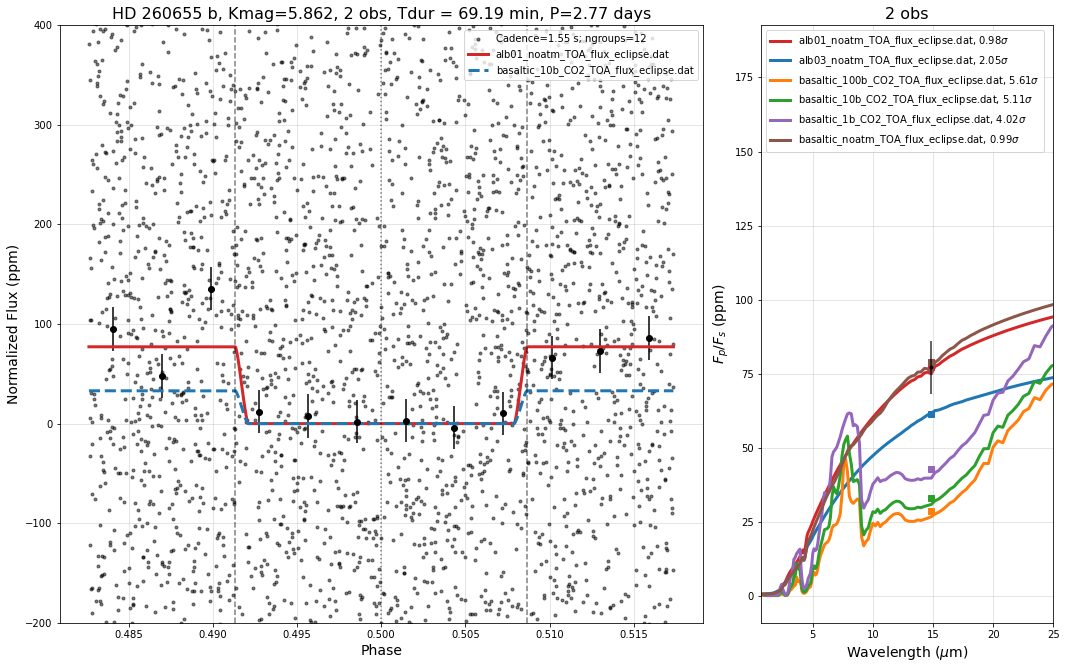

In [12]:
targ = sample[2]
starname = targ['hostname'].replace(' ', '')
input_spec_path = f'{stellar_spec_directory}{starname}_SPHINX_spec.dat'
targ['ngroup'] = process_target(targ, Fp_Fs_from_model=True, Albedos=[], display_figure=True, 
               stellar_spec='input', input_spec_path=input_spec_path)

hostname  pl_name  sy_dist    rastr         decstr    sy_kmag  st_mass st_rad st_raderr1 st_raderr2 st_teff    pl_tranmid    pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2     pl_orbper     pl_orbpererr1   pl_orbpererr2  pl_orbsmax pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 tran_flag rv_flag      pl_rp_rs             pl_g            pl_teq_a0            pl_s            pl_rho      filter subarray nobs ngroup
-------- --------- ------- ------------ ------------- -------- ------- ------ ---------- ---------- ------- ---------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- ----------------- -------------- --------------- ---------- ---------- ----------- --------------- --------------- --------- ------- ------------------ ------------------ ----------------- ----------------- ---------------- ------ -------- ---- ------
 GJ 3473 GJ 3473 b 27.3644 08h02m22.47s +03d20

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:921: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ngroup is in the 5-10 range --> adding 1 group
ETC Warnings:
{'partial_saturated': 'Partial saturation:\n There are 1 pixels saturated at the end of a ramp. Partial ramps may still be used in some cases.'}
number of groups per integration (ngroup) 7
time to take one frame (tframe) 2.77504 s
time per single integration (tframe*ngroup): 19.42528 s
cadence (integration time plus reset): 22.20032 s
number of in-occultation integrations: 152.78399341931538
observing efficiency (%): 87.5
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
GJ 3473 b --> GJ3473b
Data point: 235.99800000000005 +/- 29.91343789597466 ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 1.0809913304051748
    sigma 1.0397073292062475
alb03_noatm_TOA_flux_eclipse.dat
    chisq_red 3.6110709438202986
    sigma 1.9002818064224831
basaltic_100b_CO2_cloudy_TOA_flux_eclipse.dat

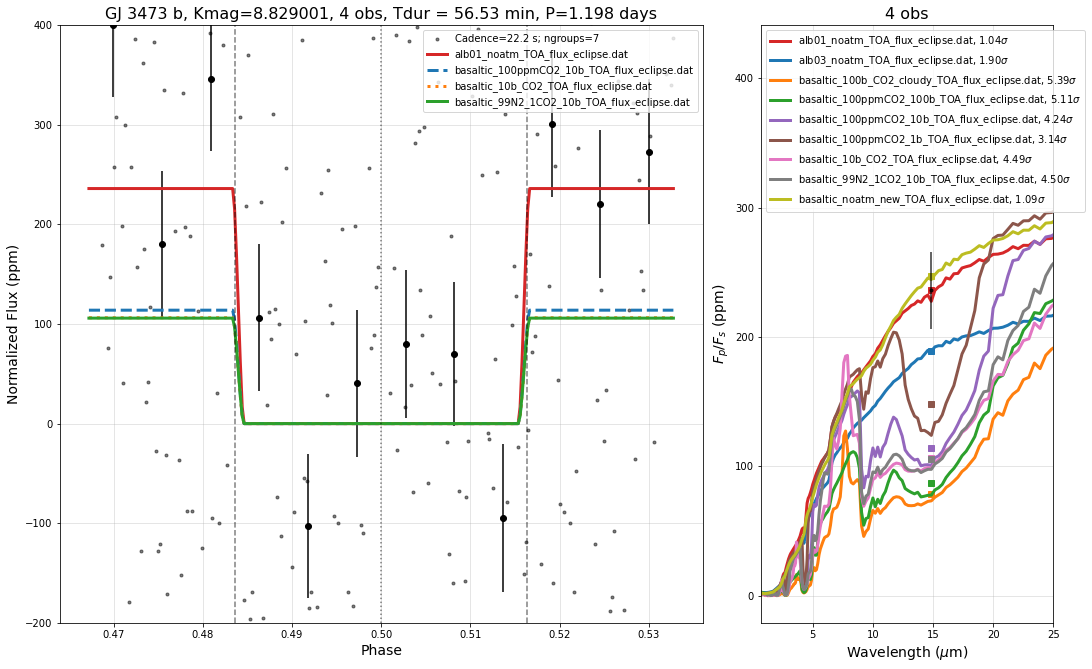

hostname pl_name  sy_dist    rastr         decstr    sy_kmag st_mass st_rad st_raderr1 st_raderr2 st_teff     pl_tranmid    pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2     pl_orbper      pl_orbpererr1   pl_orbpererr2  pl_orbsmax pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 tran_flag rv_flag       pl_rp_rs             pl_g           pl_teq_a0            pl_s              pl_rho      filter subarray nobs ngroup
-------- -------- ------- ------------ ------------- ------- ------- ------ ---------- ---------- ------- ----------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- ------------------ -------------- --------------- ---------- ---------- ----------- --------------- --------------- --------- ------- ------------------- ----------------- ----------------- ------------------ ----------------- ------ -------- ---- ------
  GJ 357 GJ 357 b 9.44181 09h36m01.79s -21

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:921: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ngroup is in the 5-10 range --> adding 1 group
ETC Warnings:
{'partial_saturated': 'Partial saturation:\n There are 1 pixels saturated at the end of a ramp. Partial ramps may still be used in some cases.'}
number of groups per integration (ngroup) 8
time to take one frame (tframe) 0.29952 s
time per single integration (tframe*ngroup): 2.39616 s
cadence (integration time plus reset): 2.6956800000000003 s
number of in-occultation integrations: 1767.561935804021
observing efficiency (%): 88.88888888888889
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
GJ 357 b --> GJ357b
Data point: 112.54871666666668 +/- 15.397434086331698 ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 0.9809591789069542
    sigma 0.990433833684495
alb03_noatm_TOA_flux_eclipse.dat
    chisq_red 3.3932322655580993
    sigma 1.842072817658982
basaltic_100b_CO2_TOA_flux_

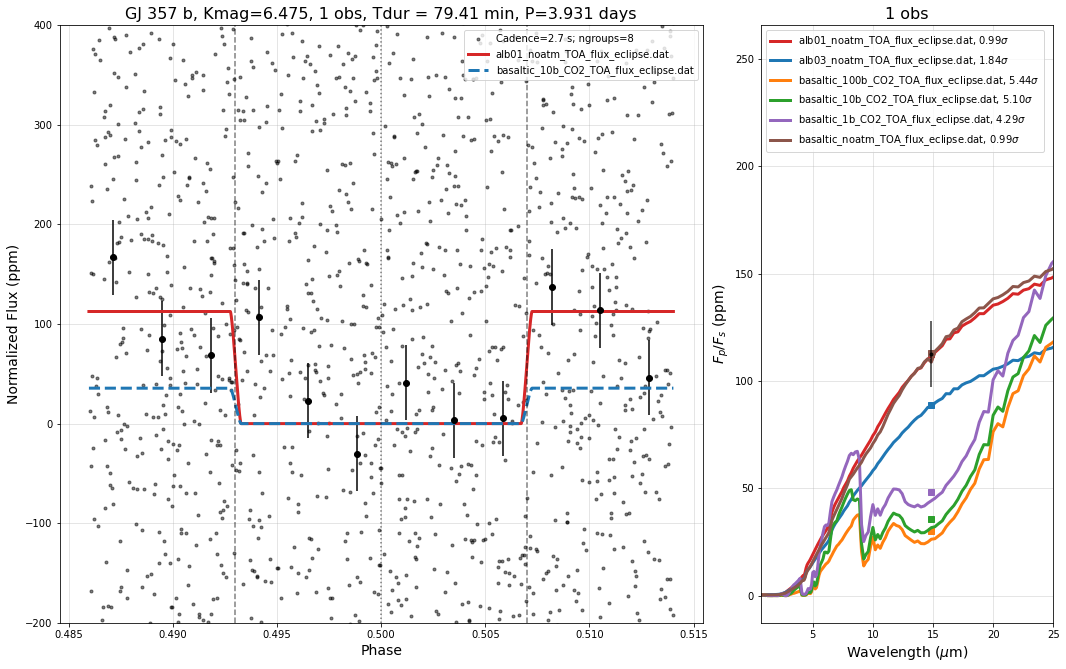

 hostname   pl_name   sy_dist    rastr         decstr    sy_kmag st_mass st_rad st_raderr1 st_raderr2 st_teff  pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 tran_flag rv_flag       pl_rp_rs             pl_g           pl_teq_a0            pl_s              pl_rho      filter subarray nobs ngroup
--------- ----------- ------- ------------ ------------- ------- ------- ------ ---------- ---------- ------- ------------ -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- ---------- ---------- ----------- --------------- --------------- --------- ------- ------------------- ----------------- ----------------- ------------------ ----------------- ------ -------- ---- ------
HD 260655 HD 260655 b 10.0055 06h37m09.97s +17d33m58.57s   5.862    

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:921: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ETC Warnings:
{}
number of groups per integration (ngroup) 12
time to take one frame (tframe) 0.11904 s
time per single integration (tframe*ngroup): 1.42848 s
cadence (integration time plus reset): 1.54752 s
number of in-occultation integrations: 2682.717598015533
observing efficiency (%): 92.3076923076923
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
HD 260655 b --> HD260655b
Data point: 77.12211666666668 +/- 8.880998822007129 ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 0.9608152693890438
    sigma 0.9802118492392626
alb03_noatm_TOA_flux_eclipse.dat
    chisq_red 4.204522610583361
    sigma 2.0504932603116157
basaltic_100b_CO2_TOA_flux_eclipse.dat
    chisq_red 31.44276288713267
    sigma 5.607384674438937
basaltic_10b_CO2_TOA_flux_eclipse.dat
    chisq_red 26.12810621519161
    sigma 5.111565925936162
basaltic_1b_CO2_TOA_flux_

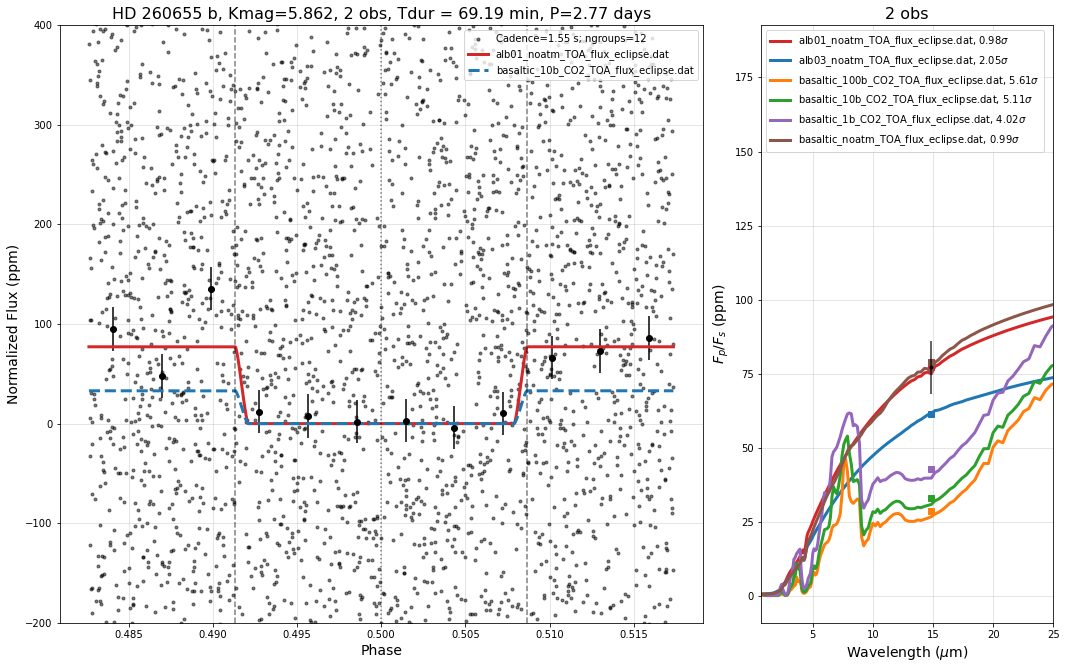

hostname  pl_name  sy_dist    rastr         decstr    sy_kmag st_mass st_rad st_raderr1 st_raderr2 st_teff   pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 tran_flag rv_flag       pl_rp_rs             pl_g           pl_teq_a0            pl_s              pl_rho       filter subarray nobs ngroup
-------- --------- ------- ------------ ------------- ------- ------- ------ ---------- ---------- ------- ------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- ---------- ---------- ----------- --------------- --------------- --------- ------- ------------------- ----------------- ----------------- ------------------ ------------------ ------ -------- ---- ------
 L 98-59 L 98-59 c 10.6194 08h18m07.89s -68d18m52.08s   7.101    0.27 

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:921: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ETC Warnings:
{}
number of groups per integration (ngroup) 13
time to take one frame (tframe) 0.29952 s
time per single integration (tframe*ngroup): 3.8937600000000003 s
cadence (integration time plus reset): 4.193280000000001 s
number of in-occultation integrations: 837.1851682365667
observing efficiency (%): 92.85714285714285
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
L 98-59 c --> L9859c
Data point: 170.78283333333334 +/- 23.069977588439375 ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 1.0652378590082472
    sigma 1.0321036086596447
alb03_noatm_TOA_flux_eclipse.dat
    chisq_red 3.554057957631385
    sigma 1.885220930721751
basaltic_100b_CO2_TOA_flux_eclipse.dat
    chisq_red 30.70626915925284
    sigma 5.541323773183881
basaltic_10b_CO2_TOA_flux_eclipse.dat
    chisq_red 27.030980181611113
    sigma 5.199132637432047
basalt

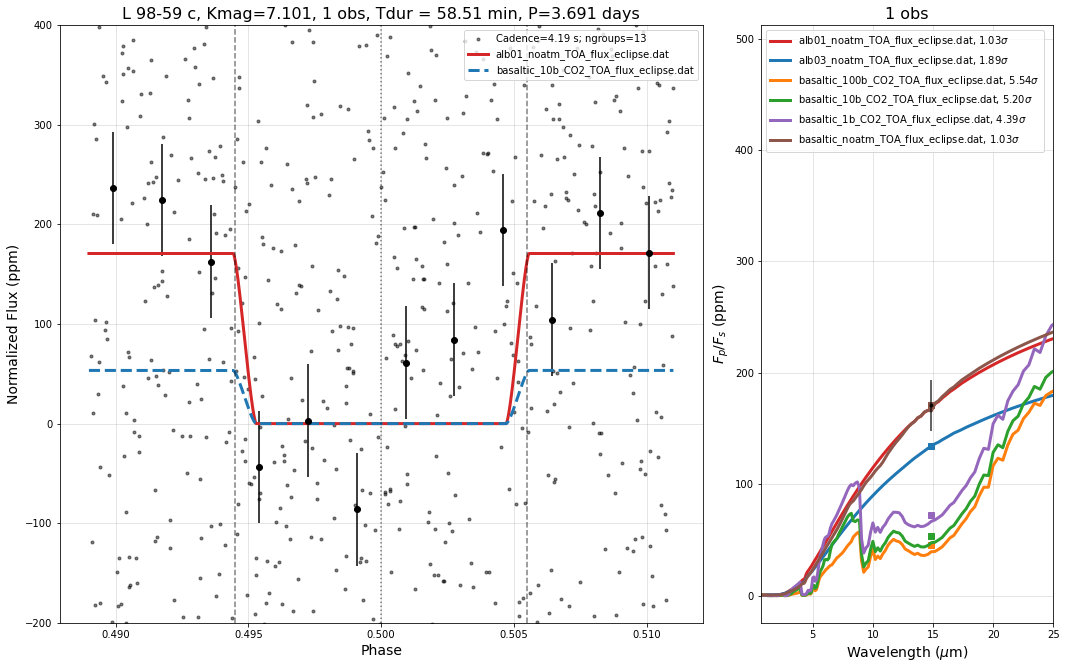

hostname  pl_name   sy_dist    rastr         decstr    sy_kmag st_mass st_rad st_raderr1 st_raderr2 st_teff    pl_tranmid   pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2  pl_orbper  pl_orbpererr1   pl_orbpererr2  pl_orbsmax pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 tran_flag rv_flag       pl_rp_rs             pl_g           pl_teq_a0            pl_s              pl_rho      filter subarray nobs ngroup
-------- ---------- ------- ------------ ------------- ------- ------- ------ ---------- ---------- ------- --------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- ----------- -------------- --------------- ---------- ---------- ----------- --------------- --------------- --------- ------- ------------------- ----------------- ----------------- ------------------ ----------------- ------ -------- ---- ------
LHS 1140 LHS 1140 c 14.9861 00h44m59.67s -15d16m26.79s  

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:921: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ngroup is in the 5-10 range --> adding 1 group
ETC Warnings:
{'partial_saturated': 'Partial saturation:\n There are 5 pixels saturated at the end of a ramp. Partial ramps may still be used in some cases.'}
number of groups per integration (ngroup) 7
time to take one frame (tframe) 2.77504 s
time per single integration (tframe*ngroup): 19.42528 s
cadence (integration time plus reset): 22.20032 s
number of in-occultation integrations: 175.60664911112355
observing efficiency (%): 87.5
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
LHS 1140 c --> LHS1140c
Data point: 183.19500000000002 +/- 30.309432549918117 ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 1.0586050824234383
    sigma 1.0288853592230045
alb03_noatm_TOA_flux_eclipse.dat
    chisq_red 2.7729839746505887
    sigma 1.665227904717727
basaltic_100b_CO2_TOA_flux_eclipse.dat
    

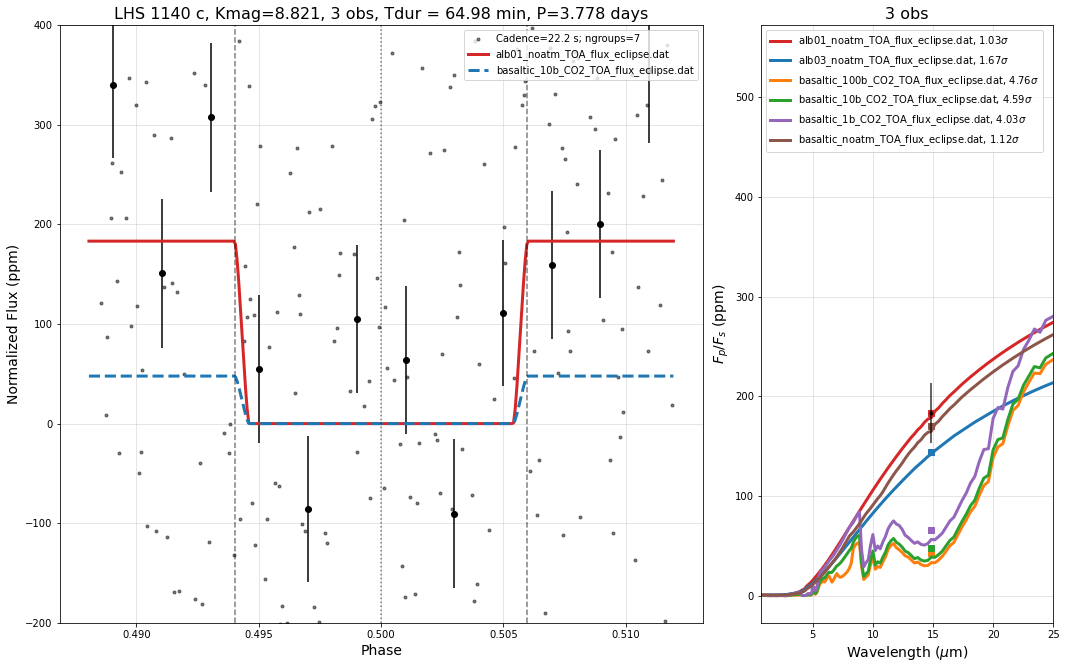

hostname  pl_name   sy_dist    rastr         decstr    sy_kmag st_mass st_rad st_raderr1 st_raderr2 st_teff   pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 tran_flag rv_flag       pl_rp_rs              pl_g            pl_teq_a0            pl_s              pl_rho      filter subarray nobs ngroup
-------- ---------- ------- ------------ ------------- ------- ------- ------ ---------- ---------- ------- ------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- ---------- ---------- ----------- --------------- --------------- --------- ------- -------------------- ------------------ ----------------- ------------------ ----------------- ------ -------- ---- ------
LHS 1478 LHS 1478 b 18.2276 02h57m21.33s +76d33m05.06s   8.767    

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:921: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ngroup is in the 5-10 range --> adding 1 group
ETC Warnings:
{'partial_saturated': 'Partial saturation:\n There are 1 pixels saturated at the end of a ramp. Partial ramps may still be used in some cases.'}
number of groups per integration (ngroup) 7
time to take one frame (tframe) 2.77504 s
time per single integration (tframe*ngroup): 19.42528 s
cadence (integration time plus reset): 22.20032 s
number of in-occultation integrations: 117.2465976416008
observing efficiency (%): 87.5
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
LHS 1478 b --> LHS1478b
Data point: 301.53022222222216 +/- 45.53683405374138 ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 1.0821226830126611
    sigma 1.0402512595583213
alb03_noatm_TOA_flux_eclipse.dat
    chisq_red 3.0825420075271546
    sigma 1.7557169497180207
basaltic_100b_CO2_TOA_flux_eclipse.dat
    c

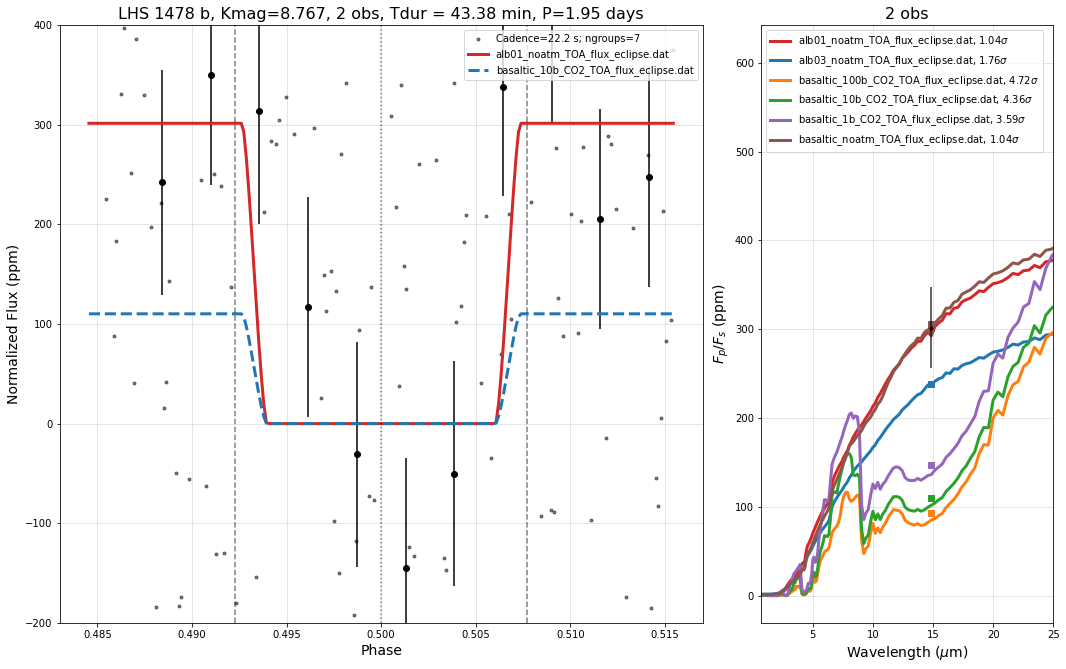

hostname  pl_name   sy_dist    rastr         decstr    sy_kmag  st_mass st_rad st_raderr1 st_raderr2 st_teff   pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 tran_flag rv_flag       pl_rp_rs              pl_g           pl_teq_a0            pl_s              pl_rho      filter  subarray nobs ngroup
-------- ---------- ------- ------------ ------------- -------- ------- ------ ---------- ---------- ------- ------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- ---------- ---------- ----------- --------------- --------------- --------- ------- -------------------- ----------------- ----------------- ------------------ ----------------- ------ --------- ---- ------
LTT 3780 LTT 3780 b 21.9814 10h18m34.78s -11d43m04.08s 8.204001 

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:921: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ETC Warnings:
{}
number of groups per integration (ngroup) 12
time to take one frame (tframe) 0.86528 s
time per single integration (tframe*ngroup): 10.38336 s
cadence (integration time plus reset): 11.24864 s
number of in-occultation integrations: 244.12650260332492
observing efficiency (%): 92.3076923076923
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
LTT 3780 b --> LTT3780b
Data point: 309.8384444444444 +/- 31.55354543177351 ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 1.0696214625084748
    sigma 1.0342250540904951
alb03_noatm_TOA_flux_eclipse.dat
    chisq_red 4.726158625436379
    sigma 2.1739730047625647
alb05_noatm_TOA_flux_eclipse.dat
    chisq_red 15.56969804579976
    sigma 3.9458456692830444
basaltic_100b_CO2_TOA_flux_eclipse.dat
    chisq_red 31.57844969475042
    sigma 5.6194705884763225
basaltic_10b_CO2_TOA_flux_e

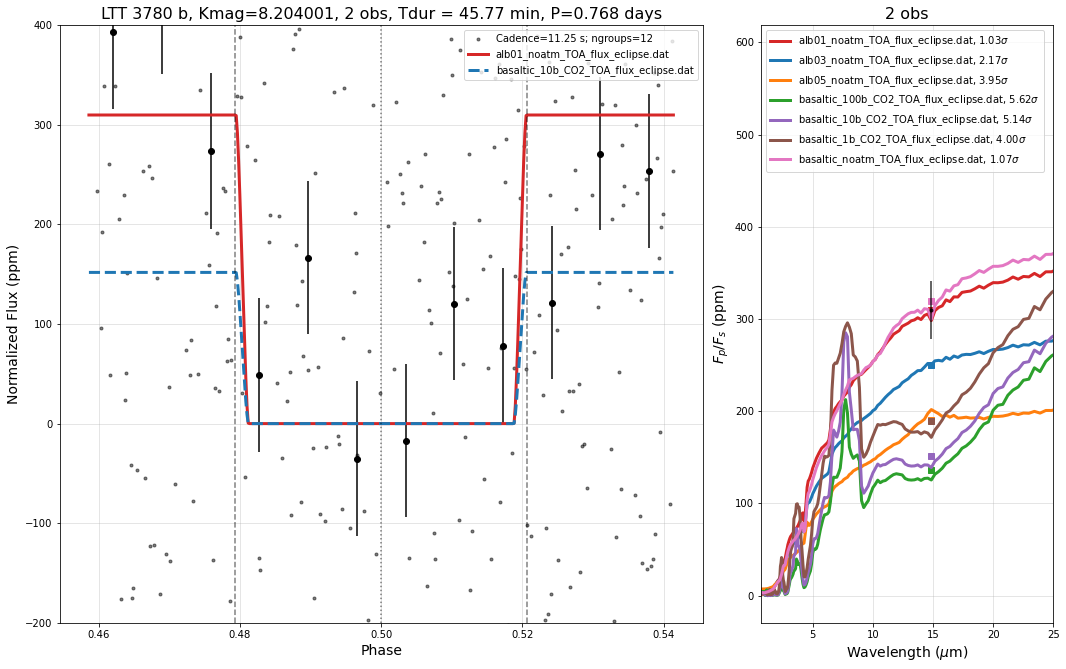

hostname  pl_name   sy_dist    rastr         decstr    sy_kmag st_mass st_rad st_raderr1 st_raderr2 st_teff   pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 tran_flag rv_flag       pl_rp_rs             pl_g            pl_teq_a0            pl_s             pl_rho      filter subarray nobs ngroup
-------- ---------- ------- ------------ ------------- ------- ------- ------ ---------- ---------- ------- ------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- ---------- ---------- ----------- --------------- --------------- --------- ------- ------------------- ------------------ ----------------- ----------------- ----------------- ------ -------- ---- ------
TOI-1468 TOI-1468 b 24.7399 01h06m36.93s +19d13m29.71s   8.497    0.34

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:921: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ngroup is in the 5-10 range --> adding 1 group
ETC Warnings:
{'partial_saturated': 'Partial saturation:\n There are 5 pixels saturated at the end of a ramp. Partial ramps may still be used in some cases.'}
number of groups per integration (ngroup) 6
time to take one frame (tframe) 2.77504 s
time per single integration (tframe*ngroup): 16.65024 s
cadence (integration time plus reset): 19.42528 s
number of in-occultation integrations: 194.8392105036238
observing efficiency (%): 85.71428571428571
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
TOI-1468 b --> TOI1468b
Data point: 196.39355555555557 +/- 28.83361593647906 ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 1.0704041770434665
    sigma 1.0346033911811228
alb03_noatm_TOA_flux_eclipse.dat
    chisq_red 3.0959449359271343
    sigma 1.7595297485200792
basaltic_100b_CO2_TOA_flux_ecli

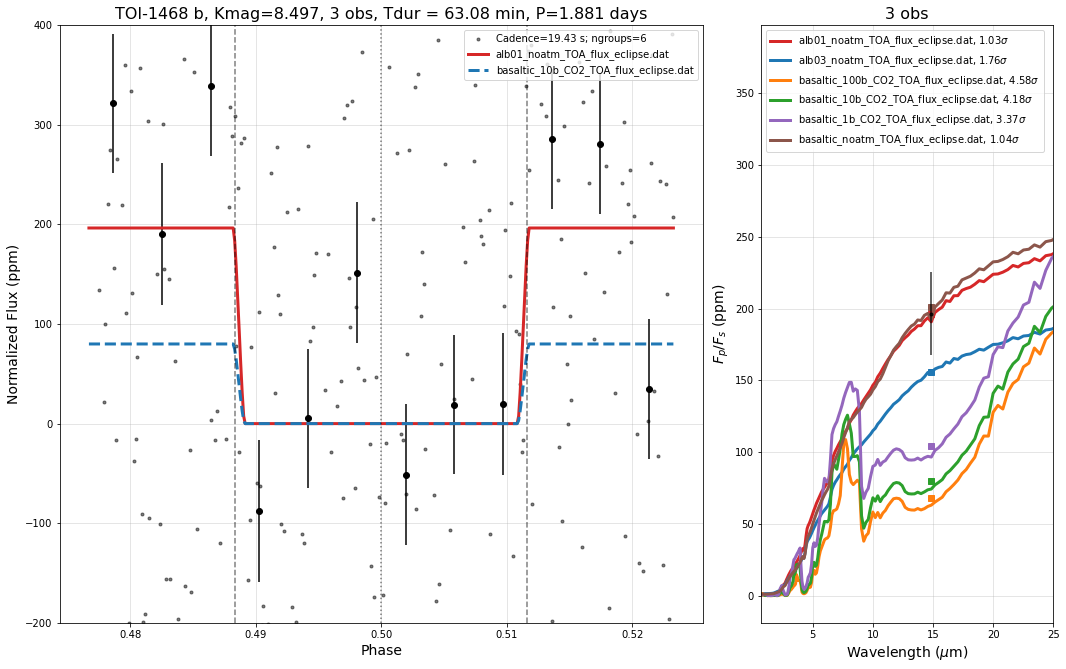

hostname  pl_name  sy_dist    rastr         decstr    sy_kmag st_mass st_rad st_raderr1 st_raderr2 st_teff   pl_tranmid  pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 tran_flag rv_flag       pl_rp_rs              pl_g           pl_teq_a0            pl_s              pl_rho      filter  subarray nobs ngroup
-------- --------- ------- ------------ ------------- ------- ------- ------ ---------- ---------- ------- ------------- -------------- -------------- ------- ----------- ----------- --------- ------------- ------------- --------- ------------- ------------- ---------- ---------- ----------- --------------- --------------- --------- ------- -------------------- ----------------- ----------------- ------------------ ----------------- ------ --------- ---- ------
 TOI-270 TOI-270 b  22.453 04h33m39.86s -51d57m26.62s   8.251   0.38

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:921: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ETC Warnings:
{}
number of groups per integration (ngroup) 13
time to take one frame (tframe) 0.86528 s
time per single integration (tframe*ngroup): 11.24864 s
cadence (integration time plus reset): 12.11392 s
number of in-occultation integrations: 426.5206909178017
observing efficiency (%): 92.85714285714286
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{'flat_unsupported_spectrum': 'Unsupported configuration parameter, spectrum, being passed to Flat.'}
TOI-270 b --> TOI270b
Data point: 106.24578333333335 +/- 16.88652788847811 ppm
alb01_noatm_TOA_flux_eclipse.dat
    chisq_red 1.0615375688075437
    sigma 1.0303094529351637
alb03_noatm_TOA_flux_eclipse.dat
    chisq_red 2.959859029591334
    sigma 1.7204240842278802
basaltic_100b_CO2_TOA_flux_eclipse.dat
    chisq_red 20.957872531923197
    sigma 4.5779769038215115
basaltic_10b_CO2_TOA_flux_eclipse.dat
    chisq_red 18.08823271108602
    sigma 4.253026300304998
basaltic_1b_CO2_TOA_flu

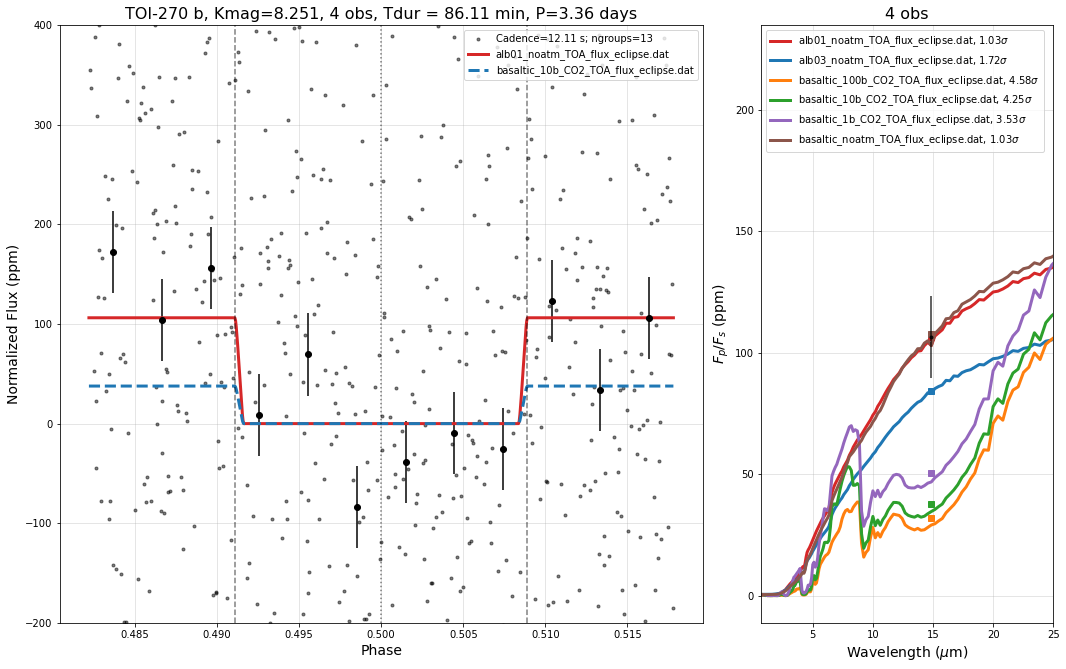

In [13]:
%matplotlib inline
for targ in sample:
    starname = targ['hostname'].replace(' ', '')
    input_spec_path = f'{stellar_spec_directory}{starname}_SPHINX_spec.dat'
    targ['ngroup'] = process_target(targ, Fp_Fs_from_model=True, Albedos=[], display_figure=True, 
                   stellar_spec='input', input_spec_path=input_spec_path)

In [14]:
ascii.write(sample, 'sample_final.csv', overwrite=True)

In [15]:
sample

hostname,pl_name,sy_dist,rastr,decstr,sy_kmag,st_mass,st_rad,st_raderr1,st_raderr2,st_teff,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_orbincl,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,tran_flag,rv_flag,pl_rp_rs,pl_g,pl_teq_a0,pl_s,pl_rho,filter,subarray,nobs,ngroup
str9,str11,float64,str12,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,str6,str9,int64,int64
GJ 3473,GJ 3473 b,27.3644,08h02m22.47s,+03d20m13.79s,8.829001,0.36,0.36,0.01,-0.01,3347.0,2458492.20412163,0.00037015,-0.00037015,1.264,0.05,-0.049,1.86,0.3,-0.3,1.198003975976397,5.76582216e-07,-5.76582216e-07,0.01589,87.95,0.0,--,--,1,1,0.0321894750291473,11.407064002554433,768.2070915703122,57.83231621613784,5.06105605260494,f1500w,full,4,7
GJ 357,GJ 357 b,9.44181,09h36m01.79s,-21d39m54.23s,6.475,0.34,0.34,0.02,-0.02,3505.0,2458517.998679131,0.0003765,-0.0003765,1.217,0.084,-0.083,1.84,0.31,-0.31,3.9306063296116895,1.16151077e-06,-1.16151077e-06,0.035,89.12,--,--,--,1,1,0.03281564780289002,12.17283537042799,526.7769415618036,12.786873373040743,5.609388414817885,f1500w,sub256,1,8
HD 260655,HD 260655 b,10.0055,06h37m09.97s,+17d33m58.57s,5.862,0.44,0.439,0.003,-0.003,3803.0,2459497.9102,0.0003,-0.0003,1.24,0.023,-0.023,2.14,0.34,-0.34,2.76953,3e-05,-3e-05,0.02933,87.35,0.039,0.043,-0.023,1,1,0.02589563026767422,13.63720864077306,709.4729664292033,42.072735108287475,6.167627593216154,f1500w,sub128,2,12
L 98-59,L 98-59 c,10.6194,08h18m07.89s,-68d18m52.08s,7.101,0.27,0.3,0.03,-0.02,3415.0,2458367.27375,0.00013,-0.00022,1.34,0.07,-0.07,2.42,0.35,-0.34,3.6906777,1.6e-06,-2.6e-06,0.0304,88.11,0.103,0.045,-0.058,1,1,0.04094990177758612,13.20568249247054,517.3063880405923,11.891830329088151,5.5267573282965365,f1500w,sub256,1,13
LHS 1140,LHS 1140 c,14.9861,00h44m59.67s,-15d16m26.79s,8.821,0.19,0.21,0.0035,-0.0035,2988.0,2458389.2942323,0.00062395,-0.00062395,1.169,0.037,-0.038,1.76,0.17,-0.16,3.777939728,5.83523921e-06,-5.83523921e-06,0.02734,89.913,0.274,--,--,1,1,0.05103457908102151,12.61940060872384,399.3229614135901,4.2223523461028085,6.053946228618852,f1500w,full,3,7
LHS 1478,LHS 1478 b,18.2276,02h57m21.33s,+76d33m05.06s,8.767,0.24,0.25,0.01,-0.01,3381.0,2458786.75425,0.00042,-0.00042,1.242,0.051,-0.049,2.33,0.2,-0.2,1.9495378,4e-06,-4.1e-06,0.01848,87.452,--,--,--,1,1,0.045546069857697276,14.800207739484296,599.6495187649439,21.470754020600786,6.682832228969028,f1500w,full,2,7
LTT 3780,LTT 3780 b,21.9814,10h18m34.78s,-11d43m04.08s,8.204001,0.4,0.37,0.01,-0.01,3331.0,2458543.91281,0.00048,-0.00052,1.32,0.06,-0.06,2.47,0.24,-0.24,0.768377,1.4e-06,-1.4e-06,0.01203,85.9,0.064,0.075,-0.046,1,1,0.032707061524655315,13.89006163347313,890.7913247681156,104.55895980434461,5.901257760073781,f1500w,brightsky,2,12
TOI-1468,TOI-1468 b,24.7399,01h06m36.93s,+19d13m29.71s,8.497,0.34,0.34,0.01,-0.01,3496.0,2458765.68079,0.0007,-0.00069,1.28,0.038,-0.039,3.21,0.24,-0.24,1.8805136,2.4e-06,-2.6e-06,0.02102086,88.47,--,--,--,1,1,0.03451440360534036,19.197301030931996,677.9832124158797,35.08593869199558,8.410940260139574,f1500w,full,3,6
TOI-270,TOI-270 b,22.453,04h33m39.86s,-51d57m26.62s,8.251,0.386,0.38,0.008,-0.008,3506.0,2458387.09505,0.00074,-0.00074,1.206,0.039,-0.039,1.58,0.26,-0.26,3.3601538,4.8e-06,-4.8e-06,0.03197,89.39,0.034,0.025,-0.025,1,1,0.029095982841969084,10.64431095709798,582.8619296384281,19.165497515761714,4.949765091265365,f1500w,brightsky,4,13


In [16]:
Albedos=np.array([0.0, 0.3, 0.5])

In [17]:
#i = 9
#process_target(sample[i-1], Fp_Fs_from_model=True, Albedos=[0.1, 0.2], display_figure=True, save_figure=False)

Approximate observing time per eclipse observation: 3.440893972850165 h
Creating MIRI dictionary
Computing background
Using existing background
Returning MIRI dictionary


/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:921: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


ETC Warnings:
{}
number of groups per integration 7
time per single integration: 19.42528 s
cadence (integration time plus reset): 22.20032 s
number of in-occultation integrations: 152.78399341931538
observing efficiency (%): 87.5
Creating MIRI calibration dictionary
Returning MIRI calibration dictionary
Calibartion Warnings:
{}
GJ 3473 b --> GJ3473b
points binned to 8.822681918550508 min
Data point: 235.99800000000005 +/- 31.008107850467276 ppm
0
    chisq_red 0.939927750981612
    sigma 0.9694987111810012
1
    chisq_red 8.885909625477783
    sigma 2.9809242904639133
2
    chisq_red 18.386022961998414
    sigma 4.287892601499997


(0.0, 300.0)

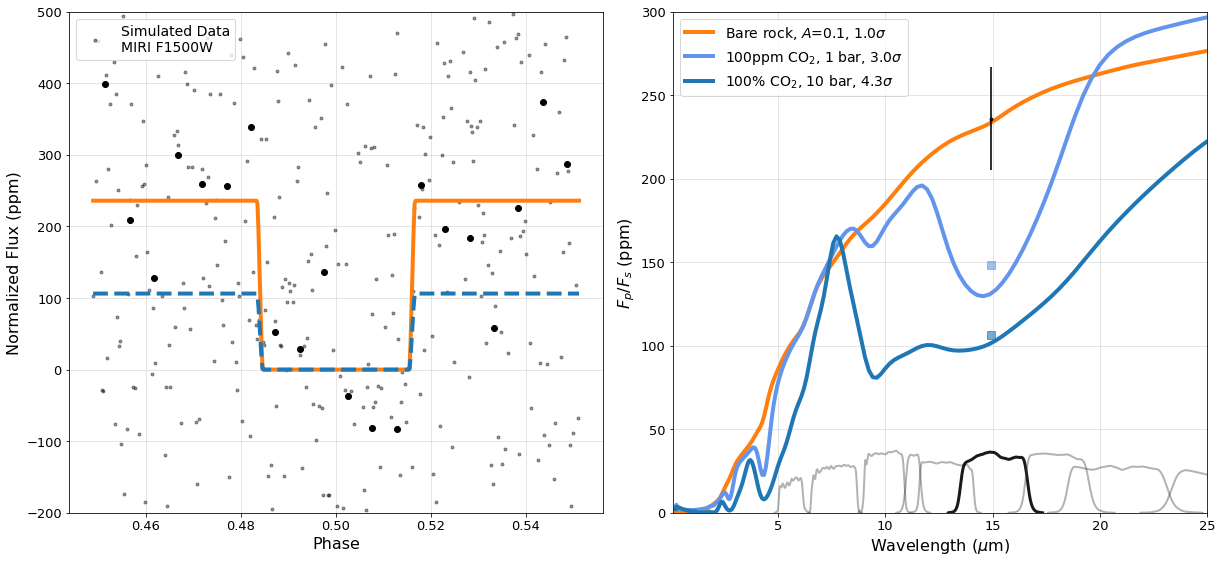

In [18]:
%matplotlib inline
from astropy.convolution import Gaussian1DKernel, convolve

targ = sample[0]
ndraws = 1000
filter = targ['filter']
subarray = targ['subarray']
nobs = targ['nobs']

# star_params
star_name = targ['hostname']
k_mag = targ['sy_kmag']

# planet params
tdur = orb.Tdur(P=targ['pl_orbper']*u.day, 
                Rp_Rs=((targ['pl_rade']*u.R_earth)/(targ['st_rad']*u.R_sun)).decompose(),
                a_Rs = ((targ['pl_orbsmax']*u.AU)/(targ['st_rad']*u.R_sun)).decompose(),
                i = targ['pl_orbincl']
               ) # event duration

# obs params
tfrac   = 1.06      # how many times occuldation duration to observe
tsettle = 30 * u.min    # should be specific to MIRI
tcharge = 1 * u.hr      # amount of charged time becuase JWST will not start observations right away
noccultations = 1       # can always scale later
mingroups = 5           # suggested for MIRI Imaging TSO
expfact_out = 1         # bare minimum of out-of-transit baseline; but will be asking for more so not a big deal


approx_obs_time = (tdur + tfrac*tdur + tsettle + tcharge).to(u.hr)
print('Approximate observing time per eclipse observation:', approx_obs_time)

# make the pandeia-2.0 dictionary for miri
miri_imaging_ts = make_miri_dict(filter, subarray, targ)

report = perform_calculation(miri_imaging_ts)
ngroup = int(report['scalar']['sat_ngroups'])  # use as many groups as possible without saturating
if ngroup > 300: ngroup = 300        # ngroups > 300 not recommended due to cosmic rays
miri_imaging_ts['configuration']['detector']['ngroup'] = ngroup

report = perform_calculation(miri_imaging_ts)

print('ETC Warnings:')
print(report['warnings']) # should be empty if nothing is wrong

tframe  = report['information']['exposure_specification']['tframe'] * u.s
tint    = tframe * ngroup                         # amount of time per integration
treset  = 1*tframe                                # reset time between each integration
cadence = tint + treset
nint    = (tdur/(tint + treset)).decompose()      # number of in-transit integrations
ref_wave = report['scalar']['reference_wavelength']                         * u.micron

print('number of groups per integration', ngroup)
print('time per single integration:', tint)
print('cadence (integration time plus reset):', cadence)
print('number of in-occultation integrations:', nint.decompose())
print('observing efficiency (%):', (tint/cadence).decompose()*100)

# the wavelength and throughput of the designated filter
bandpass_wave = report['1d']['fp'][0]
bandpass_flux = report['1d']['fp'][1]

# make a special dictionary, based off of the first MIRI dictionary, to get flux in useful units
miri_imaging_ts_calibration = make_miri_calib_dict(miri_imaging_ts)
report_calibration = perform_calculation(miri_imaging_ts_calibration)
print('Calibartion Warnings:')
print(report_calibration['warnings']) #should be empty if nothing is wrong

# compute uncertainty in a single measurement
snr = report['scalar']['sn']
extracted_flux = report['scalar']['extracted_flux'] / u.s
extracted_noise = report['scalar']['extracted_noise'] / u.s

calibration_extracted_flux = report_calibration['scalar']['extracted_flux'] / u.s
calibration_norm_value = report_calibration['input']['scene'][0]['spectrum']['normalization']['norm_flux']

signal = extracted_flux / calibration_extracted_flux * calibration_norm_value  * u.erg/u.s/u.cm**2/u.AA
noise  = extracted_noise / calibration_extracted_flux * calibration_norm_value  * u.erg/u.s/u.cm**2/u.AA

noise /= np.sqrt(nobs)

tstart = (targ['pl_orbper']*u.day)*0.5 - (tdur/2) - (tdur*tfrac/2) - tcharge/2
tend   = (targ['pl_orbper']*u.day)*0.5 + (tdur/2) + (tdur*tfrac/2) + tcharge/2
trange = tend - tstart
total_int = int(np.ceil((trange/cadence).decompose()))

signal_ts = np.ones(total_int)*signal
np.random.seed(32)
scatter_ts = np.random.normal(0, noise.value, total_int) * u.erg/u.s/u.cm**2/u.AA
signal_ts_scatter = signal_ts.value + scatter_ts.value


# now get some model atmospehres
#all_spec = get_all_model_spec(targ)
#for model in all_spec.keys():
#    wave = all_spec[model][0]
#    fpfs = all_spec[model][1]

#    bandpass_inds = (wave>bandpass_wave[0]) * (wave<bandpass_wave[-1])
#    model_binned_to_bandpass = np.mean(fpfs[bandpass_inds])

#    models[model] = {}
#    models[model]['wave'] = wave
#    models[model]['fpfs'] = fpfs
#    models[model]['wave_band'] = ref_wave
#    models[model]['fpfs_band'] = model_binned_to_bandpass

plnt_name = targ['pl_name'].replace(" ", "").replace("-", "")
print(targ['pl_name'], '-->', plnt_name)
models = {}
alb01         = '../JWST_Terrestrials/'+plnt_name+'/Spectra/alb01_noatm_TOA_flux_eclipse.dat'
CO2_10b       = '../JWST_Terrestrials/'+plnt_name+'/Spectra/basaltic_10b_CO2_TOA_flux_eclipse.dat'
CO2_100ppm_1b = '../JWST_Terrestrials/'+plnt_name+'/Spectra/basaltic_100ppmCO2_1b_TOA_flux_eclipse.dat'
labels = ['Bare rock, $A$=0.1', '100ppm CO$_2$, 1 bar', '100% CO$_2$, 10 bar']

paths = [alb01, CO2_100ppm_1b, CO2_10b]

for m, path in enumerate(paths):
    model = ascii.read(path, data_start=3)
    
    wave = model['col2']
    fpfs = model['col7']
    
    bandpass_inds = (wave>bandpass_wave[0]) * (wave<bandpass_wave[-1])
    model_binned_to_bandpass = np.mean(fpfs[bandpass_inds])
    
    models[m] = {}
    models[m]['wave'] = wave
    models[m]['fpfs'] = fpfs
    models[m]['wave_band'] = ref_wave
    models[m]['fpfs_band'] = model_binned_to_bandpass

# use stary to make the system; 
# but be careful, this is just the basis; need to set the planet amplitude for each case
star = make_star(targ)

# create light curve time points (will use to compute fluxes)
time = np.linspace(tstart.value, tend.value, total_int) # times in... days?

def get_binned_signal(flux):       
    signal_ts_scatter_binned, time_bin_edges, _ = stats.binned_statistic(time, signal_ts_scatter*flux, 
                                                                         bins=20)
    time_bin_width = np.mean(np.diff(time_bin_edges))
    time_binned = time_bin_edges[:-1] + time_bin_width/2

    return time_binned, signal_ts_scatter_binned

fig = plt.figure(figsize=(17,8))
gs = gridspec.GridSpec(1, 2, left=0.06, right=0.99, bottom=0.1, top=0.97, wspace=0.13)

figure = {}
figure['lc'] = fig.add_subplot(gs[0,0])
figure['FpFs'] = fig.add_subplot(gs[0,1])

yerr = 1/report['scalar']['sn'] / np.sqrt(nint) / np.sqrt(nobs)

# based on Joao's model names
line_styles = ['-', ':', '--']
colors = ['tab:orange', 'cornflowerblue', 'C0', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

draw_eclipse_depth_bare_rock = np.random.normal(models[0]['fpfs_band'], yerr, ndraws)
dof = 1  # rough estimate; only 1 data point

for i, case in enumerate(models):
    if i==0: planet = make_planet(targ, tidally_locked=False)
    else: planet = make_planet(targ, tidally_locked=False)
    planet.map.amp = models[case]['fpfs_band']
    system = st.System(star, planet)
    flux = np.hstack(system.flux(time))
    time_binned, signal_ts_scatter_binned = get_binned_signal(flux)

    if i==0: 
        print('points binned to', np.mean(np.diff(time_binned))*24*60, 'min')
        figure['lc'].plot(time/targ['pl_orbper'], 
                         ((signal_ts_scatter*flux/signal).value -1)*1e6, 
                          '.', color='k', alpha=0.4, 
                          label='Simulated Data\nMIRI F1500W')
        figure['lc'].plot(time_binned/targ['pl_orbper'], 
                          ((signal_ts_scatter_binned/signal).value -1)*1e6, 
                          'o', markersize=6, color='k', alpha=1)

        # only plot error bar for bare rock case in Fp/Fs figure
        figure['FpFs'].errorbar(models[case]['wave_band'].value, models[case]['fpfs_band'] *1e6, 
                                yerr=yerr.value *1e6, fmt='.', color='k', elinewidth=2,
                                alpha=0.8, zorder=1000)
        print('Data point:', models[case]['fpfs_band']*1e6, '+/-', yerr*1e6, 'ppm')

    if i==0 or i==2: figure['lc'].plot(time/targ['pl_orbper'], ((signal_ts*flux/signal).value -1)*1e6, 
                      ls=line_styles[i%3], lw=4, color=colors[i])

g = Gaussian1DKernel(stddev=2)
for i, model in enumerate(models):
    print(model)

    chisq = calc_chi_sq(models[model]['fpfs_band'], draw_eclipse_depth_bare_rock, yerr) / ndraws # can do this trick since only 1 data point
    print('    chisq_red', chisq)
    sigma = calc_significance(chisq, dof)
    print('    sigma', sigma)

    z = convolve(models[model]['fpfs'], g)
    figure['FpFs'].plot(models[model]['wave'], z *1e6, lw=4, color=colors[i], 
                        label=f'{labels[i]}, {sigma:.1f}$\sigma$')
    if i!=0: figure['FpFs'].plot(models[model]['wave_band'], models[model]['fpfs_band']*1e6, 
                                's', markersize=8, color=colors[i], alpha=0.6)

wave_filter = np.linspace(0, 25, 10000)
conf= {
    "detector": {
        "nexp": 1,
        "ngroup": 10,
        "nint": 1,
        "readout_pattern": "fastr1",
        "subarray": "full"
    },
    "instrument": {
        "aperture": "imager",
        "filter": "f1800w",
        "instrument": "miri",
        "mode": "imaging"
    },
}
for f in ['f560w', 'f770w', 'f1000w', 'f1130w', 'f1280w', 'f1500w', 'f1800w', 'f2100w', 'f2550w']:
    conf["instrument"]["filter"] = f
    # create a configured instrument
    instrument_factory = InstrumentFactory(config=conf)
    # get the throughput of the instrument over the desired wavelength range
    eff = instrument_factory.get_total_eff(wave_filter)
    inds0 = eff>0
    wv, eff = wave_filter[inds0], eff[inds0]
    
    if f=='f1500w': color, lw, alpha = 'k', 3, 0.9
    else: color, lw, alpha ='#404040', 2, 0.4
    plt.plot(wv, eff*75, color=color, ls='-', lw=lw, alpha=alpha)

figure['lc'].legend(loc='upper left', fontsize=14)
per = targ['pl_orbper']
#figure['lc'].set_title(targ['pl_name']+f', Kmag={k_mag}, {nobs} obs, Tdur = {np.round(tdur.to(u.min), 2)}, P={np.round(per, 3)} days', fontsize=16)

figure['lc'].set_xlabel('Phase', fontsize=16)
figure['lc'].set_ylabel('Normalized Flux (ppm)', fontsize=16)
figure['lc'].tick_params(which='both', labelsize=13)
figure['lc'].set_ylim(0.-200, 500)
figure['lc'].grid(alpha=0.4)

figure['FpFs'].legend(loc='upper left', fontsize=14)
figure['FpFs'].set_ylabel('$F_p$/$F_s$ (ppm)', fontsize=16)
figure['FpFs'].set_xlabel('Wavelength ($\mu$m)', fontsize=16)
figure['FpFs'].tick_params(which='both', labelsize=13)
#Fp_Fs_from_model: figure['FpFs'].set_title(f'{nobs} obs', fontsize=16)
figure['FpFs'].set_xlim(0.1, 25)
figure['FpFs'].grid(alpha=0.4)
figure['FpFs'].set_ylim(0, 300)

#plt.savefig('../Figure_MockData_FpFsModels.png', dpi=200, facecolor='white')

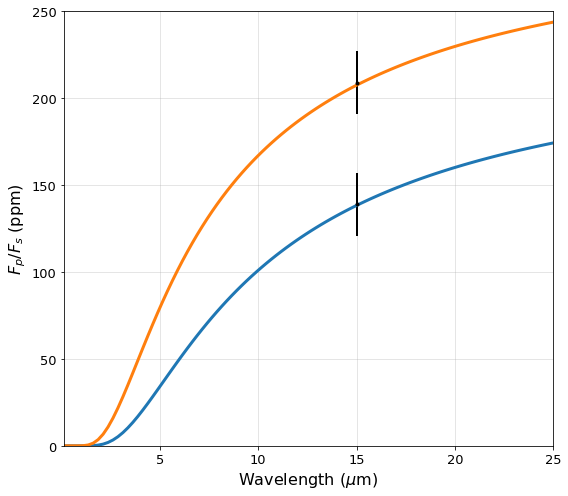

In [16]:
targ = sample[0]
wave = np.linspace(0.1, 25, 100) * u.micron
T_rock = calc_Tday(targ['st_teff']*u.K, targ['st_rad']*u.R_sun, targ['pl_orbsmax']*u.AU, atmo='bare_rock')
T_atmo = calc_Tday(targ['st_teff']*u.K, targ['st_rad']*u.R_sun, targ['pl_orbsmax']*u.AU, atmo='equilibrium')

FpFs_rock = calc_FpFs(targ['st_teff']*u.K, T_rock, wave, targ['st_rad']*u.R_sun, targ['pl_rade']*u.R_earth)
FpFs_atmo = calc_FpFs(targ['st_teff']*u.K, T_atmo, wave, targ['st_rad']*u.R_sun, targ['pl_rade']*u.R_earth)


plt.figure(figsize=(8, 7))
plt.plot(wave, FpFs_atmo*1e6, color='C0', lw=3)
plt.plot(wave, FpFs_rock*1e6, color='tab:orange', lw=3)

plt.errorbar(15, 208.998, yerr=18, fmt='.', color='k', elinewidth=2)
plt.errorbar(15, 138.998, yerr=18, fmt='.', color='k', elinewidth=2)

plt.xlim(0.1, 25)
plt.ylim(0, 250)

plt.ylabel('$F_p$/$F_s$ (ppm)', fontsize=16)
plt.xlabel('Wavelength ($\mu$m)', fontsize=16)

plt.tick_params(which='both', labelsize=13)

plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig('../Figure_Trock_Tday_Basic', dpi=200)

In [ ]:
targ['st_teff']*u.K

In [34]:
T1 = genSys.generateTransitingExoSystem(hostname="TRAPPIST-1")
T1.add_column('f1500w', name='filter')
T1.add_column('full', name='subarray')
T1.add_column(1, name='nobs')

Accessing NASA Exoplanet Archive
Table of transiting exoplanets retrieved
Writing table to ./NASAExoArchive_TransitingExoplanetSystem_TRAPPIST-1.dat


In [35]:
T1b = T1[0]
pull_default_dict = True # needs to be true if you want to pull a new default dictionary from pandeia
make_new_bkg      = True # should be true if working with different stars; otherwise set to False for speed

 hostname    pl_name     sy_dist   sy_disterr1 sy_disterr2    rastr         decstr    sy_kmag st_mass st_masserr1 st_masserr2 st_rad st_raderr1 st_raderr2 st_teff st_tefferr1 st_tefferr2   pl_tranmid   pl_tranmiderr1 pl_tranmiderr2 pl_rade pl_radeerr1 pl_radeerr2 pl_bmasse pl_bmasseerr1 pl_bmasseerr2 pl_orbper pl_orbpererr1 pl_orbpererr2 pl_orbsmax pl_orbsmaxerr1 pl_orbsmaxerr2 pl_orbincl pl_orbeccen pl_orbeccenerr1 pl_orbeccenerr2 tran_flag rv_flag filter subarray nobs
                            pc          pc          pc         deg           deg        mag     Msun      Msun        Msun     Rsun     Rsun       Rsun       K         K           K           day            day            day        Rearth    Rearth      Rearth     Mearth      Mearth        Mearth       day         day           day          AU           AU             AU          deg                                                                                       
---------- ------------ ---------- ----------- ---

<ipython-input-39-da9453cde421>:178: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  else: cases = np.hstack(models.keys())


ValueError: need at least one array to concatenate

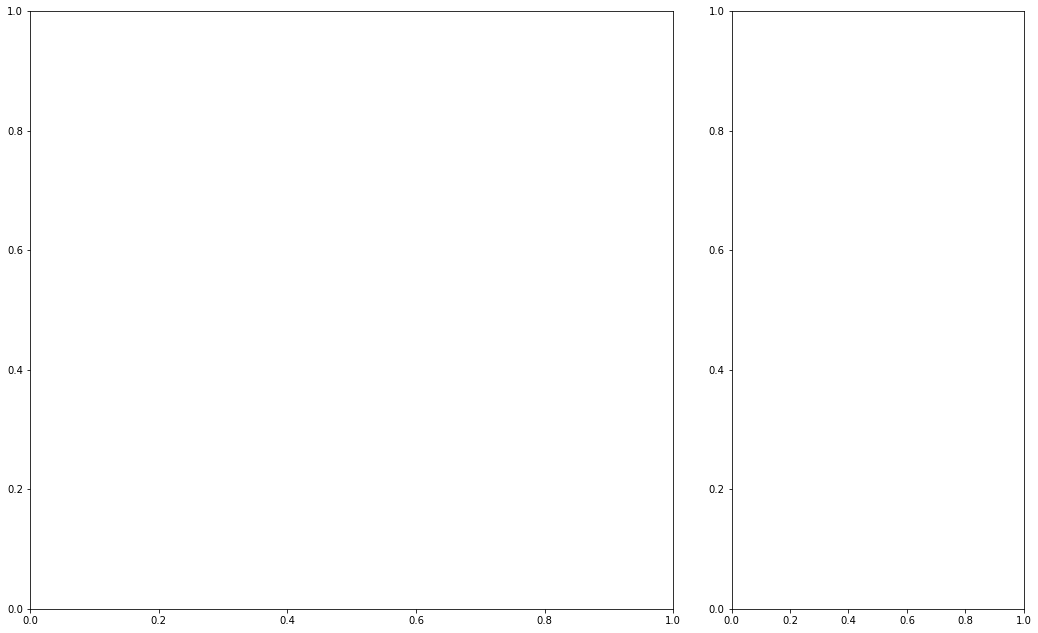

In [40]:
process_target(T1b)

In [44]:
sample['sy_kmag']

8.829001
6.475
5.862
7.101
8.821
8.767
8.204001
8.497
8.251


In [45]:
T1b['sy_kmag']

10.296

In [48]:
256*.11

28.16